<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Live-parameter-exploration" data-toc-modified-id="Live-parameter-exploration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Live parameter exploration</a></span></li><li><span><a href="#Live-interaction" data-toc-modified-id="Live-interaction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Live interaction</a></span></li><li><span><a href="#Tradeoffs-using-live-data" data-toc-modified-id="Tradeoffs-using-live-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Tradeoffs using live data</a></span></li></ul></div>


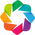

In [1]:
import holoviews as hv
import numpy as np
hv.extension('bokeh')
%opts Curve [show_grid=False xaxis=None yaxis=None]


There are many possible examples of live data, including financial data feeds, real-time scientific measurements, and sophisticated numerical simulations. Here we will consider the path traced by two very simple equations: 

 xn+1=sin(ayn)+ccos(axn)
 
 yn+1=sin(bxn)+dcos(byn)

These equations define the 'Clifford Attractor' described in the book "Chaos In Wonderland" by Cliff Pickover . Now let's write a simple Python function to iterate these two equations starting from position (x0,y0) : 

In [3]:
def clifford(a, b, c, d, x0, y0):
    xn, yn = x0, y0
    coords = [(x0, y0)]
    for i in range(10000):
        x_n1 = np.sin(a * yn) + c * np.cos(a * xn)
        y_n1 = np.sin(b * xn) + d * np.cos(b * yn)
        xn, yn = x_n1, y_n1
        coords.append((xn, yn))
    return coords

If we run this function now, we'll get a list of 10000 tuples, which won't be very informative.

The Curve element accepts the output of our clifford function, making it trivial to define a function that when called gives us a visualization:


In [4]:
def clifford_attractor(a, b, c, d):
    return hv.Curve(clifford(a, b, c, d, x0=0, y0=0))

In [5]:
%%opts Curve(line_width=0.03, color='red')
clifford_attractor(a=-1.5, b=1.5, c=-1, d=0.75)

:Curve   [x]   (y)

This HoloViews element gives us a snapshot for the four chosen values, but what we really would like to do is to interact with the four-dimensional parameter space directly, even though that parameter space is too large to compute all possible combinations feasibly. 

# Live parameter exploration

To dynamically explore these parameters, we can start by declaring a DynamicMap , passing in our function instead of the dictionary of Image elements we saw in the Introduction . We declare the four arguments of our function as kdims : 

In [6]:
dmap = hv.DynamicMap(clifford_attractor, kdims=['a', 'b', 'c', 'd'])
dmap

DynamicMap cannot be displayed without explicit indexing as 'a', 'b', 'c', 'd' dimension(s) are unbounded. 
Set dimensions bounds with the DynamicMap redim.range or redim.values methods.

:DynamicMap   [a,b,c,d]

As you can see from the error message, HoloViews does not yet have the information needed to give us a visualization--it has no way to guess any value to use for the 'a','b','c', and 'd' dimensions. Since we know what suitable values look like, we can easily specify appropriate ranges using the redim method: 

In [7]:
%%opts Curve (line_width=0.03 color='green')
# When run live, this cell's output should match the behavior of the GIF below
dmap.redim.range(a=(-1.5,-1),b=(1.5,2),c=(1,1.2),d=(0.75,0.8))

:DynamicMap   [a,b,c,d]



These ranges supplied with redim.range are semantic specifications of suitable values for each of the parameters and they are used to define suitable ranges for the interactive sliders above. Note how the HoloViews options system described in the Customization section continues to work with the DynamicMap .


# Live interaction

The live visualizations above are indistinguishable from standard HoloViews visualization, apart from the speed and memory usage. With a live Python server and the Bokeh backend, HoloViews can also be used for building highly customized forms of live interactivity using DynamicMap and the streams system . A HoloViews stream is simply a parameter of a corresponding stream class configured to track some variable that reflects a user interaction. For instance, let's write a function that accepts an initial x and y value and computes a more complex version of the above plot, showing the x , y point as a dot along with a line segment indicating the first step taken when computing the attractor and some text indicating the starting point: 

In [8]:
def interactive_clifford(a, b, c, d, x=0, y=0):
    coords = clifford(a, b, c, d, x0=x, y0=y)
    return (hv.Curve(coords) * hv.Points(coords[0]) * hv.Curve(coords[:2], group='Init')
            * hv.Text(-0.75, 1.35, 'x:{x:.2f} y:{y:.2f}'.format(x=coords[0][0], y=coords[0][1])))

All we have done is create an Overlay as described in the Introduction containing our Clifford attractor curve and a few other HoloViews elements parameterized accordingly, including Points and the Text annotation. Now by passing this function to DynamicMap and also passing in a PointerXY stream that grabs the x,y locations of the mouse (in data space), we have an explorable visualization you can interact with directly. The plot now shows the ttractor (in blue) and the starting point and first step (in red), with the starting point following the mouse position: 

In [9]:
from holoviews.streams import PointerXY

In [10]:
%%opts Curve (line_width=0.03 color='blue') Points (color='red' size=10) Curve.Init (color='red' line_width=2)
# When run live, this cell's output should match the behavior of the GIF below
dmap = hv.DynamicMap(interactive_clifford, kdims=['a','b','c','d'], streams=[PointerXY(x=0,y=0)])
dmap.redim.range(a=(-1.4,-1),b=(1.6,1.8),c=(1,1.5),d=(0.7,0.8))

:DynamicMap   [a,b,c,d]

 # Tradeoffs using live data

DynamicMap and Streams allow specification of exciting, dynamic visualizations, allowing you to build full-featured interactive applications and simulations with very little code (particularly when combined with a declarative widget library like ParamNB or ParamBokeh ). The way these dynamic visualizations work is that HoloViews runs JavaScript in your browser, which then communicates with a running Python server process that may be running in the Jupyter notebook server or in the Bokeh server . This Python process may be running locally on your machine or on some remote internet or local-network server. Regardless of where it is running, this Python process executes the callback you supply to DynamicMap , allowing HoloViews to update your visualization whenever the parameters change.

This architecture is powerful and fully general, as you can always make static content in memory into dynamic output generated by a function (see the User Guide to learn more). Using live data is not always recommended, however, because using purely static content also has some important advantages:
Reasons to use live data

    Your data is inherently coming from a live source and your visualization needs to reflect this in real time.
    You wish to explore a large parameter space and statically sampling this space adequately is prohibitive in memory or computation time.
    Your data is too big to fit in memory and you only need to explore a portion of it that you can stream in from disk.
    You want an open-ended visualization that keeps updating indefinitely.

Reasons to use static data

    You wish to archive or record your visualization in such a way that they exist independently of code execution in a potentially changing codebase.
    You wish to share visualizations in a static HTML file that does not require running a live server (e.g a file that can be e-mailed and immediately viewed or placed on an HTML server).

The general recommendation is to visualize your data with HoloMap (as in the introduction to this guide) when you have a small amount of data (typically a few megabytes) that can be quickly computed and can reasonably be embedded into an HTML file. Otherwise, you can use DynamicMap that you can sample from to generate a HoloMap from when you wish to share your results (see the user guide for more information on how to turn your DynamicMap objects into HoloMap s). 